In [1]:
%matplotlib inline
import os
import logging
import sys
import numpy as np
import matplotlib.pyplot as plt

import nems
import nems.initializers
import nems.priors
import nems.utils
import nems.xforms as xforms
import nems.db as nd
import nems.recording as recording

log = logging.getLogger(__name__)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2018-12-06 123855.log


In [2]:
#TODO write set_setting command
nems.get_setting('SQL_ENGINE')

# better cofiguration management?
# use $HOME/.config/nems/settings.py?
# vs. default: nems/nems/settings/config.py

# saved setting?

'sqlite'

### Set basic parameters, file locations ###

In [3]:
# figure out data and results paths:
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
signals_dir = nems.get_setting('NEMS_RECORDINGS_DIR')

# ----------------------------------------------------------------------------
# DATA LOADING & PRE-PROCESSING
recording.get_demo_recordings(name="TAR010c-18-1.pkl")

datafile = os.path.join(signals_dir, "TAR010c-18-1.pkl")
load_command = 'nems.demo.loaders.demo_loader'
exptid = "TAR010c"
batch = 271
cellid = "TAR010c-18-1"

# MODEL SPEC
#modelspecname = 'wc.18x1.g-fir.1x15-lvl.1'
modelspecname = 'dlog-wc.18x1.g-fir.1x15-lvl.1'
#modelspecname = 'dlog-wc.18x1.g-stp.1-fir.1x15-lvl.1-dexp.1'

meta = {'cellid': cellid, 'batch': batch, 'modelname': modelspecname,
        'recording': exptid}

### generate xforms spec ###

In [4]:
xfspec = []
# load internally (NEMS native format):
#xfspec.append(['nems.xforms.load_recordings',
#               {'recording_uri_list': [recording_uri]}])
# load from external format
xfspec.append(['nems.xforms.load_recording_wrapper',
               {'load_command': load_command,
                'exptid': exptid,
                'datafile': datafile}])
xfspec.append(['nems.xforms.split_by_occurrence_counts',
               {'epoch_regex': '^STIM_'}])
xfspec.append(['nems.xforms.average_away_stim_occurrences', {}])

# generate modelspec
xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspecname, 'meta': meta}])

# do the fit
xfspec.append(['nems.xforms.fit_basic_init', {}])
xfspec.append(['nems.xforms.fit_basic', {}])
# xfspec.append(['nems.xforms.fit_basic_shrink', {}])
#xfspec.append(['nems.xforms.fit_basic_cd', {}])
# xfspec.append(['nems.xforms.fit_iteratively', {}])

# test performance
xfspec.append(['nems.xforms.predict', {}])
xfspec.append(['nems.xforms.add_summary_statistics',    {}])

# GENERATE PLOTS
xfspec.append(['nems.xforms.plot_summary', {}])

In [5]:
xfspec[0]

['nems.xforms.load_recording_wrapper',
 {'load_command': 'nems.demo.loaders.demo_loader',
  'exptid': 'TAR010c',
  'datafile': '/Users/svd/python/nems/recordings/TAR010c-18-1.pkl'}]

In [6]:
# these are the contents of load_recording_wrapper

from nems.demo.loaders import dummy_loader, demo_loader
from nems.signal import RasterizedSignal
from nems.recording import Recording

data = demo_loader(datafile)

signals = {}
fs = data.get('fs',100)
meta = data.get('meta', {})
epochs = data.get('epochs', None)
for k in data.keys():
    if k in ['fs', 'meta', 'epochs']:
        pass
    elif k.endswith('_labels'):
        # these wil
        pass
    else:
        signals[k] = RasterizedSignal(fs, data[k], k, exptid, epochs=epochs,
                                      chans=data.get(k+'_labels'))

rec = Recording(signals)
rec.signals

{'resp': <nems.signal.RasterizedSignal at 0x1c183584a8>,
 'stim': <nems.signal.RasterizedSignal at 0x1c18358d68>}

### do the fit ###

[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /Users/svd/python/nems/recordings/TAR010c_770631f383abffabda11540b5d97a60a0d45edc5.tgz
[nems.xforms INFO] Evaluating: nems.xforms.split_by_occurrence_counts
[nems.xforms INFO] Evaluating: nems.xforms.average_away_stim_occurrences
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: dlog
[nems.initializers INFO] kw: wc.18x1.g
[nems.initializers INFO] kw: fir.1x15
[nems.initializers INFO] kw: lvl.1
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.initializers INFO] target_module: levelshift found at modelspec[3].
[nems.initializers INFO] Mod 3 (nems.modules.levelshift.levelshift) fixing level to response mean 0.208
[nems.initializers INFO] resp has 1 channels
[nems.analysis.fit_basic INFO] Data len pre-mask: 51150
[nems.analysis.fit_basic INFO] Data len post-mask: 49500
[nems.fitters.fitter INFO] Starting sigma: [0.0, 0.5, 0.3191538

CHANS: 
['2.0', '2.2900951398765637', '2.6222678748431285', '3.002621457816346', '3.438144403717148', '3.936838894573224', '4.507867809469581', '5.161723080836149', '5.910418470405774', '6.767710306856466', '7.74935024091226', '8.873374661957223', '10.160436093826037', '11.634182658748713', '13.321692581618315', '15.253971718046882', '17.466523247656863', '19.999999999999996']


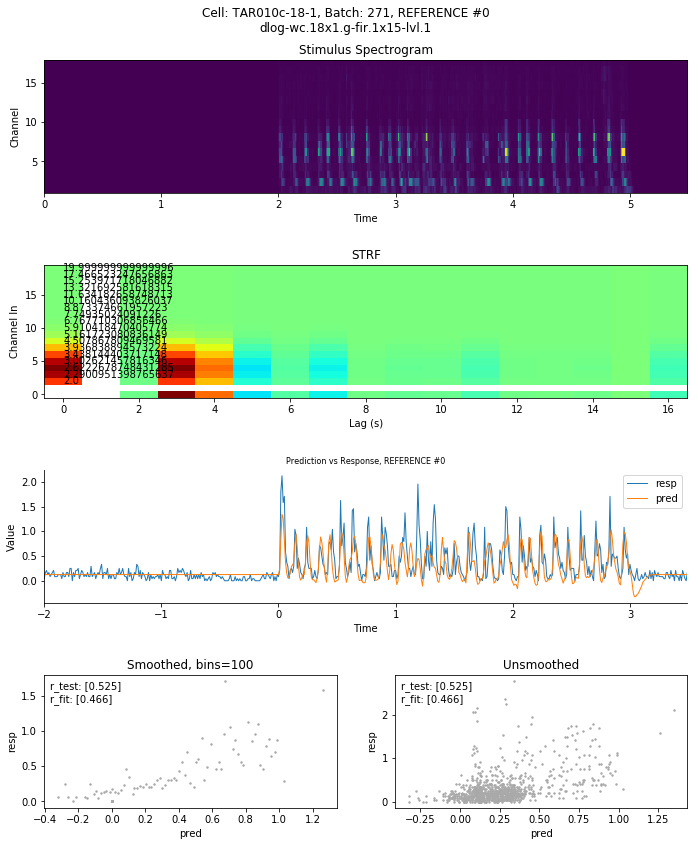

In [7]:
# actually do the fit
log_xf = "NO LOG"
ctx = {}
for xfa in xfspec:
    ctx = xforms.evaluate_step(xfa, ctx)
    
# alternative:
#ctx, log_xf = xforms.evaluate(xfspec)

In [10]:
ctx['modelspec'].meta['r_fit']

array([0.46630456])

In [12]:
modelspec = ctx['modelspec']
meta=modelspec['meta']
print(meta)

{'cellid': 'TAR010c-18-1', 'batch': 271, 'modelname': 'dlog-wc.18x1.g-fir.1x15-lvl.1', 'recording': 'TAR010c', 'fitter': 'fit_basic', 'fit_time': 22.04756474494934, 'n_parms': 19, 'r_test': array([0.52456176]), 'se_test': array([0.05449473]), 'r_floor': array([0.07809823]), 'mse_test': array([0.85693408]), 'se_mse_test': array([0.03854133]), 'll_test': 1.6592215977842293, 'r_fit': array([0.46630456]), 'se_fit': array([0.02525704]), 'r_ceiling': array([0.54750667]), 'mse_fit': array([0.8846316]), 'se_mse_fit': array([0.01332902]), 'll_fit': 1.6008910285126978}


### save results ###

In [13]:
modelspec = ctx['modelspec']

# save to file
destination = os.path.join(results_dir, str(batch), xforms.get_meta(ctx)['cellid'],
                           modelspec.get_longname())
log.info('Saving modelspec(s) to {0} ...'.format(destination))
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=modelspec,
                     xfspec=xfspec,
                     figures=ctx['figures'],
                     log=log_xf)

# save summary to a database
log.info('Saving metadata to db  ...')
modelspec.meta['modelpath'] = destination
modelspec.meta['figurefile'] = destination + 'figure.0000.png'
nd.update_results_table(modelspec)


[__main__ INFO] Saving modelspec(s) to /Users/svd/python/nems/results/271/TAR010c-18-1/TAR010c.dlog_wc.18x1.g_fir.1x15_lvl.1.fit_basic.2018-12-06T204732 ...
[__main__ INFO] Saving metadata to db  ...


4

### reload the model from db ###

In [14]:
batch = 271
cellid = "TAR010c-18-1"

# MODEL SPEC
#modelspecname = 'wc.18x1.g-fir.1x15-lvl.1'
modelspecname = 'dlog-wc.18x1.g-fir.1x15-lvl.1'
#modelspecname = 'dlog-wc.18x1.g-stp.1-fir.1x15-lvl.1-dexp.1'

In [58]:
# find the results in the database
d=nd.get_results_file(batch=batch, cellids=[cellid], modelnames=[modelspecname])
filepath = d['modelpath'][0] + '/'

# load and display results
xfspec, ctx = xforms.load_analysis(filepath, eval_model=True)


[nems.xforms INFO] Loading modelspec from /Users/svd/python/nems/results/271/TAR010c-18-1/TAR010c.dlog_wc.18x1.g_fir.1x15_lvl.1.fit_basic.2018-12-06T173229/...
[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file /Users/svd/python/nems/recordings/TAR010c_770631f383abffabda11540b5d97a60a0d45edc5.tgz
[nems.xforms INFO] Evaluating: nems.xforms.split_by_occurrence_counts
[nems.xforms INFO] Evaluating: nems.xforms.average_away_stim_occurrences
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic
[nems.xforms INFO] Evaluating: nems.xforms.predict
[nems.xforms INFO] Evaluating: nems.xforms.add_summary_statistics
[nems.xforms INFO] Evaluating: nems.xforms.plot_summary
[nems.xforms INFO] Done (re-)evaluating xforms.


In [21]:
dir(nems._config)

['DEFAULT_EXEC_PATH',
 'DEFAULT_SCRIPT_PATH',
 'KEYWORD_PLUGINS',
 'MYSQL_DB',
 'MYSQL_HOST',
 'MYSQL_PASS',
 'MYSQL_PORT',
 'MYSQL_USER',
 'NEMS_LOG_CONSOLE_FORMAT',
 'NEMS_LOG_CONSOLE_LEVEL',
 'NEMS_LOG_FILENAME',
 'NEMS_LOG_FILE_FORMAT',
 'NEMS_LOG_FILE_LEVEL',
 'NEMS_LOG_ROOT',
 'NEMS_RECORDINGS_DIR',
 'NEMS_RESULTS_DIR',
 'SQL_ENGINE',
 'SYSTEM',
 'XFORMS_PLUGINS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'configure_logging',
 'datetime',
 'init_settings',
 'logging',
 'os',
 'socket']

Get saved data from Results table

In [59]:
d.loc[0]

id                                                             4
cellid                                              TAR010c-18-1
batch                                                        271
modelname                          dlog-wc.18x1.g-fir.1x15-lvl.1
r_test                                                  0.524562
r_fit                                                   0.466305
score                                                          0
sparsity                                                       0
modelpath      /Users/svd/python/nems/results/271/TAR010c-18-...
modelfile                                                       
figurefile     /Users/svd/python/nems/results/271/TAR010c-18-...
githash                                                         
lastmod                                      2018-12-06 09:32:29
r_ceiling                                               0.550333
r_floor                                                0.0765246
n_parms                  

Find all models fit for this cell/batch

In [68]:
d=nd.get_results_file(batch=batch, cellids=[cellid])
d[['cellid','modelname','r_fit','r_test','modelpath']]

,cellid,modelname,r_fit,r_test,modelpath
0,TAR010c-18-1,dlog-wc.18x1.g-fir.1x15-lvl.1,0.466305,0.524562,/Users/svd/python/nems/results/271/TAR010c-18-...
1,TAR010c-18-1,dlog-wc.18x1.g-stp.1-fir.1x15-lvl.1-dexp.1,0.535871,0.601526,/Users/svd/python/nems/results/271/TAR010c-18-...
2,TAR010c-18-1,wc.18x1.g-fir.1x15-lvl.1,0.412346,0.544093,/Users/svd/python/nems/results/271/TAR010c-18-...
3,TAR010c-18-1,wc.18x2.g-fir.2x15-lvl.1,0.419215,0.557903,


### some other inspection stuff ###

Get some basic info about the fit

In [69]:
print("List of modules in this modelspec:")
print(modelspec)

print("Number of modules: {}".format(len(modelspec)))
print("Number of fits: {}".format(modelspec.fit_count()))

List of modules in this modelspec:
nems.modules.nonlinearity.dlog
nems.modules.weight_channels.gaussian
nems.modules.fir.basic
nems.modules.levelshift.levelshift
Number of modules: 4
Number of fits: 1


Plotting support built in to ModelSpec:

In [72]:
modelspec[0]['plot_fns']

['nems.plots.api.mod_output',
 'nems.plots.api.pred_resp',
 'nems.plots.api.before_and_after',
 'nems.plots.api.spectrogram']

In [76]:
modelspec[0]['plot_fn_idx']=1

In [78]:
modelspec.plot?

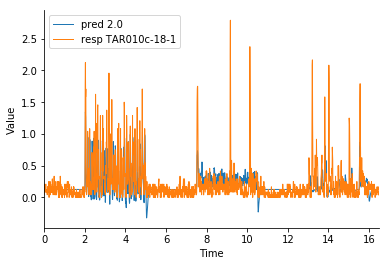

In [81]:
modelspec.plot(mod_index=0, plot_fn_idx=1, rec=ctx['val'])

nems.modules.fir.basic


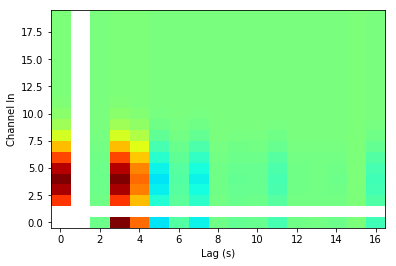

In [82]:
modelspec.recording = ctx['val']
print(modelspec[2]['fn'])
modelspec.plot(mod_index=2)

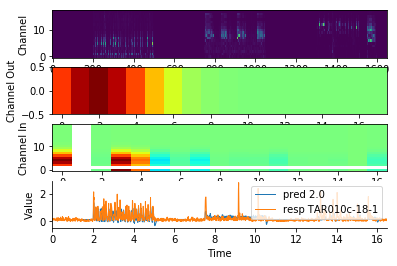

In [83]:
modelspec.recording = ctx['val']
modelspec[0]['plot_fn_idx']=3
fig=modelspec.quickplot()

In [84]:
print("Recording views:", ctx['val'].view_count())

# list of views for looping through fit sets (eg, nfold fits)
ctx['val'].views()

Recording views: 1
